NMS(Non-Max Supression)-非极大值抑制
===

# 1.NMS
## 1.1.NMS介绍
在目标检测中，常会利用非极大值抑制算法(NMS，non maximum suppression)对生成的大量候选框进行后处理，去除冗余的候选框，得到最佳检测框，以加快目标检测的效率

其本质思想是其思想是搜素局部最大值，抑制非极大值，如下图

![image](Images/03_02_001.jpg)

每个选出来的Bounding Box检测框用$x,y,h,w, confidence score，Pdog,Pcat$表示，confidence score表示background和foreground的置信度得分，取值范围$[0,1]$。Pdog,Pcat分布代表类别是狗和猫的概率。如果是100类的目标检测模型，BBox输出向量为5+100=105

## 1.2.NMS算法过程
NMS主要就是通过迭代的形式，不断的以最大得分的框去与其他框做IoU操作，并过滤那些IoU较大（即交集较大）的框。

![image](Images/03_02_002.jpg)
![image](Images/03_02_003.jpg)

- 根据候选框的类别分类概率做排序，假如有4个BBox，其置信度A>B>C>D
- 先标记最大概率矩形框A是算法要保留的BBox
- 从最大概率矩形框A开始，分别判断ABC与D的重叠度IOU（两框的交并比）是否大于某个设定的阈值(0.5)，假设D与A的重叠度超过阈值，那么就舍弃D
- 从剩下的矩形框BC中，选择概率最大的B，标记为保留，然后判读C与B的重叠度，扔掉重叠度超过设定阈值的矩形框
- 一直重复进行，标记完所有要保留下来的矩形框
- 如果是two stage算法，通常在选出BBox有BBox位置(x,y,h,w)和confidence score，没有类别的概率。因为程序是生成BBox，再将选择的BBox的feature map做rescale(一般用ROI pooling)，然后再用分类器分类。NMS一般只能在CPU计算，这也是two stage相对耗时的原因
- 但如果是one stage作法，BBox有位置信息(x,y,h,w)、confidence score，以及类别概率，相对于two stage少了后面的rescale和分类程序，所以计算量相对少。

# 1.3.NMS计算

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
def nms_python(bboxes, threshold):
    bboxes = bboxes.astype('float')
    x_min = bboxes[:, 0]
    y_min = bboxes[:, 1]
    x_max = bboxes[:, 2]
    y_max = bboxes[:, 3]
    psocres = bboxes[:, 4]
    # Sorting the pscores in descending order and keeping respective indices.
    sorted_idx = psocres.argsort()[::-1]
    # Calculating areas of all bboxes.Adding 1 to the side values to avoid zero area bboxes.
    bbox_areas = (x_max - x_min + 1) * (y_max - y_min + 1)

    # list to keep filtered bboxes.
    filtered = []
    while len(sorted_idx) > 0:
        # Keeping highest pscore bbox as reference.
        rbbox_i = sorted_idx[0]
        # Appending the reference bbox index to filtered list.
        filtered.append(rbbox_i)

        # Calculating (xmin,ymin,xmax,ymax) coordinates of all bboxes w.r.t to reference bbox
        overlap_xmins = np.maximum(x_min[rbbox_i], x_min[sorted_idx[1:]])
        overlap_ymins = np.maximum(y_min[rbbox_i], y_min[sorted_idx[1:]])
        overlap_xmaxs = np.minimum(x_max[rbbox_i], x_max[sorted_idx[1:]])
        overlap_ymaxs = np.minimum(y_max[rbbox_i], y_max[sorted_idx[1:]])

        # Calculating overlap bbox widths,heights and there by areas.
        overlap_widths = np.maximum(0, (overlap_xmaxs - overlap_xmins + 1))
        overlap_heights = np.maximum(0, (overlap_ymaxs - overlap_ymins + 1))
        overlap_areas = overlap_widths * overlap_heights

        # Calculating IOUs for all bboxes except reference bbox
        ious = overlap_areas / (bbox_areas[rbbox_i] + bbox_areas[sorted_idx[1:]] - overlap_areas)

        # select indices for which IOU is greather than threshold
        delete_idx = np.where(ious > threshold)[0] + 1
        delete_idx = np.concatenate(([0], delete_idx))

        # delete the above indices
        sorted_idx = np.delete(sorted_idx, delete_idx)

    # Return filtered bboxes
    return bboxes[filtered].astype('int')

完全按照算法，我自己实现如下

In [4]:
def iou(box1, box2):

    bbox_areas_1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    bbox_areas_2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    overlap_xmins = np.maximum(box1[0], box2[0])
    overlap_ymins = np.maximum(box1[1], box2[1])
    overlap_xmaxs = np.minimum(box1[2], box2[2])
    overlap_ymaxs = np.minimum(box1[3], box2[3])

    overlap_widths = np.maximum(0, (overlap_xmaxs - overlap_xmins + 1))
    overlap_heights = np.maximum(0, (overlap_ymaxs - overlap_ymins + 1))
    overlap_areas = overlap_widths * overlap_heights

    ious = overlap_areas / (bbox_areas_1 + bbox_areas_2 - overlap_areas)

    return ious

def nms_jjzhk(bboxes, threshold):
    boxes = bboxes[:, :4]
    pscores = bboxes[:, 4]
    D = []

    while len(boxes) > 0:
        m = np.argmax(pscores)
        M = boxes[m]
        D.append(M)
        boxes = np.delete(boxes, m, axis=0)
        pscores = np.delete(pscores, m, axis=0)

        box_copy = []
        pscores_copy = []
        for i, box in enumerate(boxes):
            iou_value = iou(M, box)
            if iou_value >= threshold:
                pass
            else:
                box_copy.append(box)
                pscores_copy.append(pscores[i])

        boxes = box_copy
        pscores = pscores_copy
    return D

## 1.4.缺点分析
1. NMS算法中的最大问题就是它将相邻检测框的分数均强制归零(既将重叠部分大于重叠阈值Nt的检测框移除)。在这种情况下，如果一个真实物体在重叠区域出现，则将导致对该物体的检测失败并降低了算法的平均检测率(average precision, AP)。
2. NMS的阈值也不太容易确定，设置过小会出现误删，设置过高又容易增大误检
3. NMS一般只能使用CPU计算，无法使用GPU计算

# 2.Soft-NMS

## 2.1.算法介绍
NMS算法是略显粗暴，因为NMS直接将删除所有IoU大于阈值的框。soft-NMS吸取了NMS的教训，在算法执行过程中不是简单的对IoU大于阈值的检测框删除，而是降低得分。算法流程同NMS相同，但是对原置信度得分使用函数运算，目标是降低置信度得分

对于置信度的调整，有两种方法,一是线性加权
$$s_i=\begin{cases}
s_i & iou(M,b_i) < N_t \\
s_i \times (1-iou(M,b_i)) \geq N_t
\end{cases}$$
二是高斯加权
$$s_i=s_i \times e^{-\frac{iou(M, b_i)^2}{\sigma}},\forall b_i \nin D$$

In [5]:
def nms_soft(bboxes, threshold, nms_threshold):
    boxes = bboxes[:, :4]
    pscores = bboxes[:, 4]
    D = []
    sort_idx = pscores.argsort()[::-1]

    while len(sort_idx) > 0:
        m = sort_idx[0]
        M = bboxes[m]
        D.append(M.copy())

        for i, box in enumerate(boxes):
            iou_value = iou(M, box)
            if iou_value < threshold:
                pass
            else:
                pscores[i] = pscores[i] * (1 - iou_value)

        sort_idx = np.delete(sort_idx, 0, axis=0)
    D = np.array(D)
    return D[np.where(D[:, 4] > nms_threshold)][:, :4]

## 2.2.优缺点
1. Soft-NMS可以很方便地引入到object detection算法中，不需要重新训练原有的模型、代码容易实现，不增加计算量（计算量相比整个object detection算法可忽略）。并且很容易集成到目前所有使用NMS的目标检测算法。
2. soft-NMS在训练中采用传统的NMS方法，仅在推断代码中实现soft-NMS。作者应该做过对比试验，在训练过程中采用soft-NMS没有显著提高。
3. NMS是Soft-NMS特殊形式，当得分重置函数采用二值化函数时，Soft-NMS和NMS是相同的。soft-NMS算法是一种更加通用的非最大抑制算法。

缺点是soft-NMS也是一种贪心算法，并不能保证找到全局最优的检测框分数重置

# 5.对比

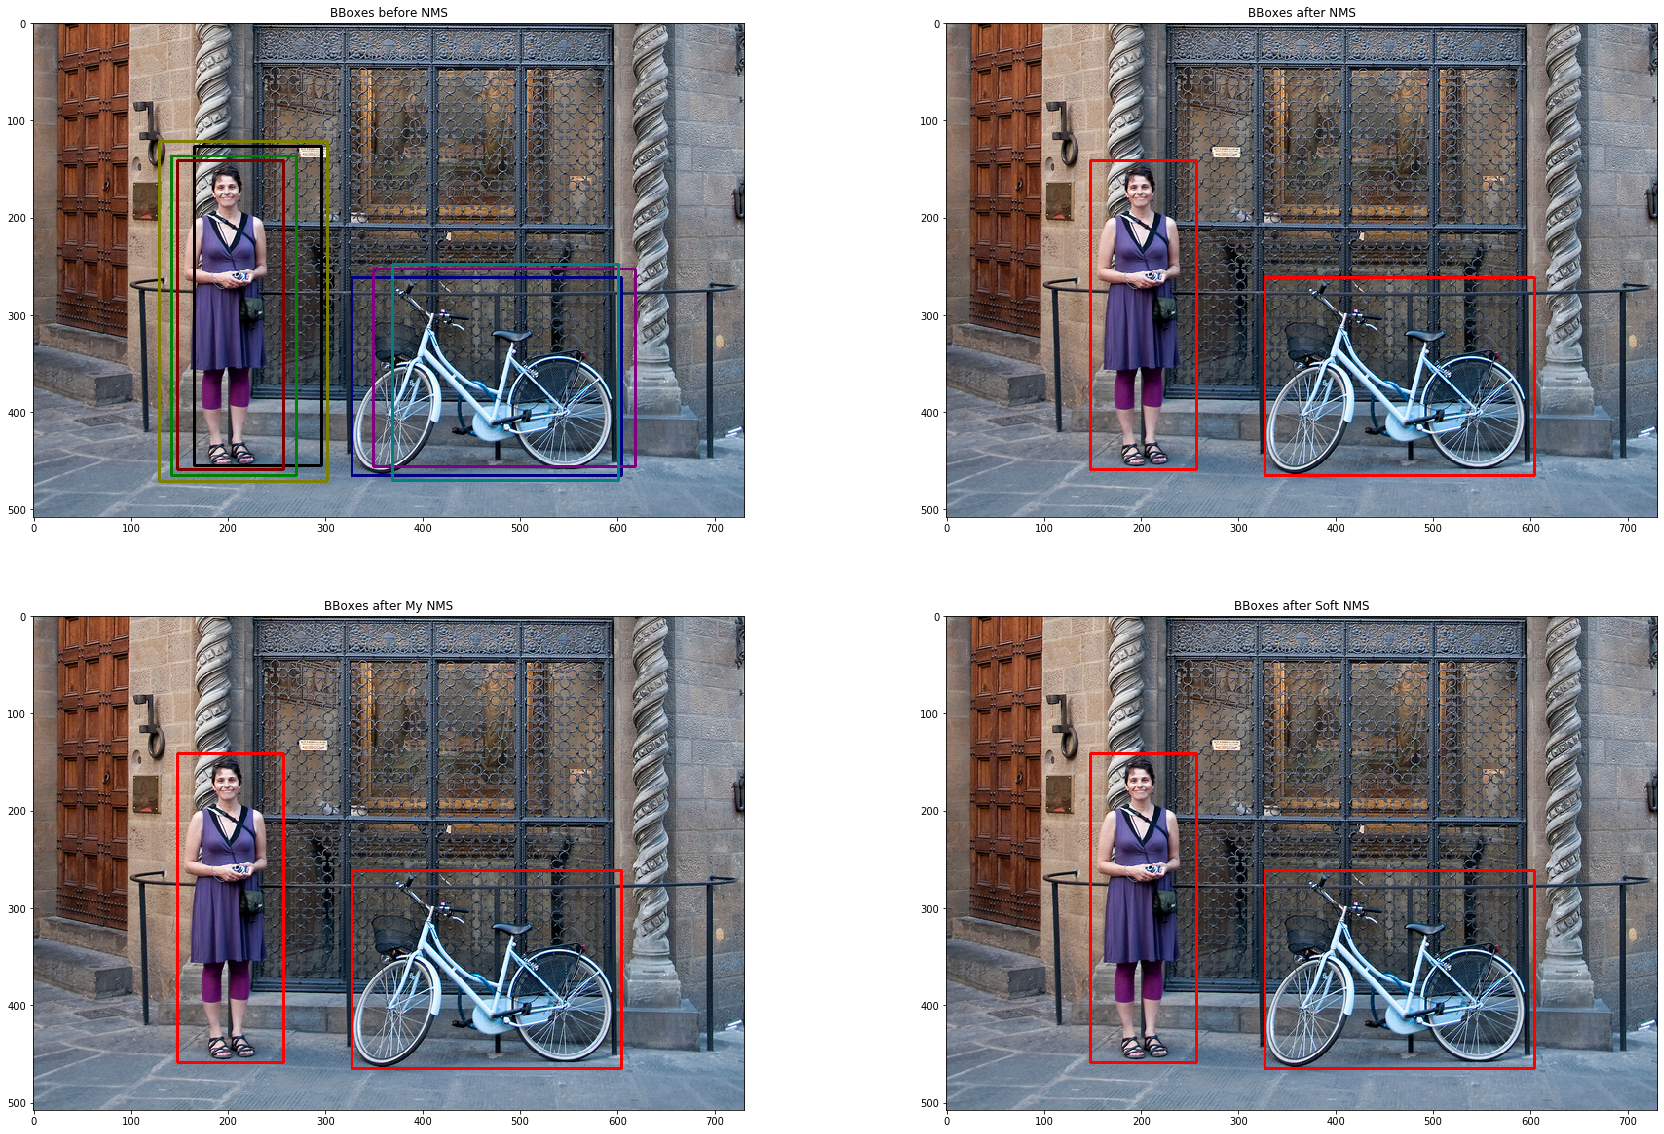

In [8]:
COLOR = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
    [0, 64, 128]
]
bboxes = np.array([
    (165, 127, 296, 455, 0.8),
    (148, 142, 257, 459, 0.95),
    (142, 137, 270, 465, 0.81),
    (129, 122, 302, 471, 0.85),
    (327, 262, 604, 465, 0.94),
    (349, 253, 618, 456, 0.83),
    (369, 248, 601, 470, 0.82)
])
sampleimage = cv2.imread("Images/03/02/03_02_004.jpg")
sampleimage = cv2.cvtColor(sampleimage,cv2.COLOR_BGR2RGB)
sampleimageallbb = sampleimage.copy()
sampleimagenmsbb1 = sampleimage.copy()
sampleimagenmsbb2 = sampleimage.copy()
sampleimagenmsbb3 = sampleimage.copy()
# Sample BBoxes and corresponding scores.

# Drawing all rectangular bboxes on original image
for index, bbox in enumerate(bboxes):
    top_left = int(bbox[0]), int(bbox[1])
    bottom_right = int(bbox[2]), int(bbox[3])
    cv2.rectangle(sampleimageallbb, top_left, bottom_right, COLOR[index], 2)
# Getting nms filtered bboxes
bboxes_after_nms_python = nms_python(bboxes, 0.3)
bboxes_after_nms_jjzhk = nms_jjzhk(bboxes, 0.3)
bboxes_after_nms_soft = nms_soft(bboxes, 0.3, 0.6)
# Drawing nms filtered rectangular bboxes on original image
for bbox in bboxes_after_nms_python:
    top_left = int(bbox[0]), int(bbox[1])
    bottom_right = int(bbox[2]), int(bbox[3])
    cv2.rectangle(sampleimagenmsbb1, top_left, bottom_right, (255, 0, 0), 2)

for bbox in bboxes_after_nms_jjzhk:
    top_left = int(bbox[0]), int(bbox[1])
    bottom_right = int(bbox[2]), int(bbox[3])
    cv2.rectangle(sampleimagenmsbb2, top_left, bottom_right, (255, 0, 0), 2)

for bbox in bboxes_after_nms_soft:
    top_left = int(bbox[0]), int(bbox[1])
    bottom_right = int(bbox[2]), int(bbox[3])
    cv2.rectangle(sampleimagenmsbb3, top_left, bottom_right, (255, 0, 0), 2)

image_list = [sampleimageallbb, sampleimagenmsbb1, sampleimagenmsbb2, sampleimagenmsbb3]
titles = ["BBoxes before NMS", "BBoxes after NMS", "BBoxes after My NMS", "BBoxes after Soft NMS"]

plt.figure(figsize=(30, 20), facecolor='w')
for i, (image, title) in enumerate(zip(image_list, titles)):
    plt.subplot(2, 2, i + 1)
    plt.title(title)
    plt.imshow(image)
plt.show()